# Genetic Algorithm Approach

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Hyperparameters

In [3]:
num_qubits = 4
batch_size = 5
n_epochs = 10
n_train = 30  
n_test = 20

population_size = 500
iterations = 10
lr = 0.01

In [4]:
def load_dataset(n_train, n_test, batch_size):
    """
    Loads train & test sets from FashionMNIST with user-specified sizes.

    Args:
        n_train (int): Desired number of samples in the training set.
        n_test (int): Desired number of samples in the testing set.
        batch_size (int): Batch size for the DataLoaders.

    Returns:
        tuple: (train_loader, test_loader) where each loader is a
               torch.utils.data.DataLoader.
    """
    # Define transformations for the dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    # Download FashionMNIST dataset
    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # Subset the datasets to the desired number of samples
    train_subset = torch.utils.data.Subset(train_dataset, range(n_train))
    test_subset = torch.utils.data.Subset(test_dataset, range(n_test))

    # Create DataLoaders for training and testing sets
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_dataset(n_train, n_test, batch_size)

## Genetic Algorithm Components

In [5]:
dev = qml.device('lightning.qubit', wires=4)

@qml.qnode(dev, interface="torch", diff_method="adjoint")
def circuit(inputs, gates):
    # Encoding of 4 classical input values
    for j in range(num_qubits):
        qml.RY(np.pi * inputs[j], wires=j)
    
    # Chromosome    
    for gate in gates:
        qml.apply(gate)

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(num_qubits)]

In [6]:
def extract_image_patches(x):
    # Do TF 'SAME' Padding
    B, C, H, W = x.shape  
    #x = torch.arange(B*C*H*W).view(B, C, H, W)
    kernel_h, kernel_w = 2, 2
    stride = 2

    patches = x.unfold(2, kernel_h, stride).unfold(3, kernel_w, stride)
      
    patches = patches.contiguous().view(B, H // stride, W // stride, -1)
    
    return patches

def quanvolute_train_test(train_loader, test_loader, gates):  # Renamed for clarity
    q_train_images = []
    q_test_images = []

    for data, _ in train_loader:  # Assuming your loader provides image, label batches
        patches = extract_image_patches(data)
        patches = patches.reshape(-1, 4)

        quanvoluted_patches = torch.stack([torch.tensor(circuit(patch, gates)) for patch in patches])
        q_train_images.append(quanvoluted_patches.view(data.size(0), 14, 14, 4))

    for data, _ in test_loader:
        patches = extract_image_patches(data)
        patches = patches.reshape(-1, 4)
        quanvoluted_patches = torch.stack([torch.tensor(circuit(patch, gates)) for patch in patches])
        q_test_images.append(quanvoluted_patches.view(data.size(0), 14, 14, 4))

    q_train_images = torch.cat(q_train_images).numpy()  # Convert to NumPy array
    q_test_images = torch.cat(q_test_images).numpy()

    return q_train_images, q_test_images

In [7]:
def QNN():
    # PyTorch model architecture 
    model = nn.Sequential(
        nn.Flatten(),  # Flattens the input tensor
        nn.Linear(in_features=784, out_features=10),  # Assuming input is 28x28 images
        nn.Softmax(dim=1)  # Applies softmax for probabilities across 10 classes
    )
    
    # PyTorch equivalent of the optimizer
    optimizer = optim.Adam(params=model.parameters(), lr=lr)  

    # PyTorch loss and metrics
    criterion = nn.CrossEntropyLoss()  # For sparse categorical targets
    # No direct equivalent for accuracy; will need a custom function 

    return model, optimizer, criterion  # Return model, optimizer, and loss

In [8]:
random.seed(137)  
np.random.seed(137)  

In [9]:
import torch
import torch.nn as nn

def evaluate_network(gates, train_loader = train_loader, test_loader = test_loader, n_epochs = n_epochs):
    q_train, q_test = quanvolute_train_test(train_loader, test_loader, gates)

    # Initialize model, optimizer, and loss function
    model, optimizer, criterion = QNN()  # Replace QNN with your model definition

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use GPU if available
    model.to(device)

    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training over batches 
        for i, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)  # Send to device

            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()  

            _, predicted = torch.max(outputs.data, 1)  # Get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total

        # Evaluation on the test set
        with torch.no_grad():  # No need for gradients during evaluation
            test_correct = 0
            test_total = 0
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

            test_accuracy = 100 * test_correct / test_total

    return test_accuracy  # Return the final test accuracy 


In [10]:
non_param_gates = [qml.CNOT, qml.Hadamard, qml.CZ]
param_gates = [qml.RX, qml.RZ]

In [11]:
def generate_random_angle():
    random_number = random.random()  # Generates a random float between 0 and 1
    angle = random_number * 2 * math.pi 
    return angle

def random_non_param_gate(n_wires):
    gate = np.random.choice(non_param_gates)
    
    if gate == qml.CNOT or gate == qml.CZ:
        wire1 = np.random.randint(n_wires)
        wire2 = np.random.choice([i for i in range(n_wires) if i != wire1])
        return gate(wires = [wire1, wire2])
    else:
        return gate(wires=np.random.randint(n_wires))

def random_param_gate(n_wires):
    gate = np.random.choice(param_gates)
    return gate(generate_random_angle(), wires=np.random.randint(n_wires))

In [12]:
def generate_random_gate_sequence(n_wires, depth):
    gates = []
    for i in range(depth):
        if np.random.rand() < 0.5:
            gate = random_non_param_gate(n_wires)
            gates.append(gate)
        else:
            gate = random_param_gate(n_wires)
            gates.append(gate)
    return gates

[RZ(0.4546925961808592, wires=[3]), RX(2.5767036351215973, wires=[1]), CZ(wires=[3, 1]), Hadamard(wires=[0]), RX(6.22195388519651, wires=[3]), RZ(1.4509273233499869, wires=[1]), CZ(wires=[3, 1]), Hadamard(wires=[0]), RX(2.1914336345710286, wires=[0]), RZ(5.156262266224696, wires=[3])]


/var/folders/pc/01wnjzvx01n_gqvkhmw2_9nr0000gn/T/ipykernel_47877/1515865988.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


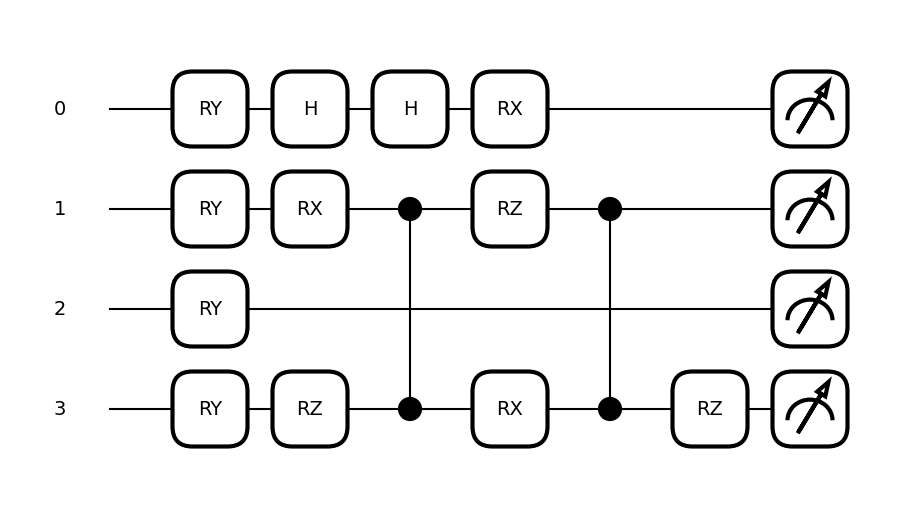

In [13]:
circ = generate_random_gate_sequence(4, 10)
print(circ)
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], circ)
fig.show()

In [14]:
# Even though we set the same weights as a starting point we'll get different results for 
# a circuit over different runs, this is due the optimizer being stochastic.
for i in range(10):
    print(f"[{i}] ", evaluate_network(circ, train_loader, test_loader, n_epochs))

[0]  40.0
[1]  35.0
[2]  40.0
[3]  45.0
[4]  35.0
[5]  30.0
[6]  20.0
[7]  35.0
[8]  35.0
[9]  15.0


## Genetic Operators

In [15]:
def fitness(gates):
    return evaluate_network(gates)

def tournament_selection(population, tournament_size=3):
    """Selects a parent by sampling 'tournament_size' individuals randomly. 
       Assumes population is a list of (individual, fitness) tuples.
    """
    participants = np.random.choice(len(population), tournament_size, replace=False)
    best_candidate_idx = participants[np.argmax([population[p][1] for p in participants])]  # Access fitness with [1]
    return population[best_candidate_idx]  # Return the entire (individual, fitness) tuple

def one_point_crossover(parent1, parent2):
    """Performs one-point crossover between two circuits. 
       Assumes parents are individuals.
    """
    crossover_point = np.random.randint(1, min(len(parent1), len(parent2))) 
    offspring1_circuit = parent1[:crossover_point] + parent2[crossover_point:]
    offspring2_circuit = parent2[:crossover_point] + parent1[crossover_point:]
    return offspring1_circuit, offspring2_circuit  

def kth_point_crossover(parent1, parent2, k):
    """Performs kth-point crossover between
        two circuits
       Assumes parents are individuals
    """
    if k < 1:
        raise ValueError("k (number of crossover points) must be at least 1")

    length = min(len(parent1), len(parent2))

    # Generate k random crossover points within the length of the parents
    crossover_points = sorted(np.random.choice(range(1, length), size=k, replace=False))

    # Initialize offspring with alternating segments
    offspring1_circuit = parent1.copy() 
    offspring2_circuit = parent2.copy()
    current_parent = 1  # Start with parent1

    # Iterate through crossover points, swapping segments 
    for i in range(len(crossover_points)):
        start = crossover_points[i - 1] if i > 0 else 0
        end = crossover_points[i]

        if current_parent == 1:
            offspring1_circuit[start:end] = parent2[start:end]
            offspring2_circuit[start:end] = parent1[start:end]
        else:
            offspring1_circuit[start:end] = parent1[start:end]
            offspring2_circuit[start:end] = parent2[start:end]

        current_parent = (current_parent + 1) % 2  # Switch parents

    return offspring1_circuit, offspring2_circuit  


def simple_mutation(individual, mutation_rate=0.05, n_wires=4):
    """Mutates a circuit with a certain probability per gate.
       Assumes parents are individuals.
    """
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            if np.random.rand() < 0.33:
                individual[i] = random_param_gate(n_wires)
            else:
                individual[i] = random_non_param_gate(n_wires)

    return individual  

def mutate_circuit(circuit, n_wires = 4):
        gate_to_mutate = np.random.choice(range(len(circuit)))
        
        circuit[gate_to_mutate] = generate_random_gate_sequence(n_wires, 1)[0]
        
        return circuit, fitness(circuit)

import time
def genetic_algorithm(n_wires, depth, pop_size, n_generations):
    initial_time = time.time()
    population = [(generate_random_gate_sequence(n_wires, np.random.randint(low=5, high=depth)), 0) for _ in range(pop_size)]
    
    for i in range(pop_size):
        population[i] = (population[i][0], fitness(population[i][0]))
    
    population = sorted(population, key=lambda x:x[1], reverse=True)
    
    print(f"Generation {0}:\n\tBest Accuracy: {population[0][1]}\n\tBest Candidate: {max(population, key=lambda x: x[1])[0]}\n\tAverage Accuracy: {np.mean([x[1] for x in population])}")  
    print("\tTime taken: {0:.2f}s".format(time.time() - initial_time))
    for k in range(n_generations):
        start_time = time.time()
        offspring = []

        for _ in range(pop_size // 2):
            parent1 = tournament_selection(population)  
            parent2 = tournament_selection(population)

            offspring1, offspring2 = kth_point_crossover(parent1[0], parent2[0], 2)
            offspring1_fitness = fitness(offspring1)  
            offspring2_fitness = fitness(offspring2)
            
            offspring.append((offspring1, offspring1_fitness)) 
            offspring.append((offspring2, offspring2_fitness))
    
        population = population + offspring
        
        mutations = []
        for circuit in population:
            if np.random.rand() < 0.5:
                mutated_circuit, mutated_fitness = mutate_circuit(circuit[0])
                mutations.append((mutated_circuit, mutated_fitness))
        
        population = population + mutations 
        population = sorted(population, key=lambda x: x[1], reverse=True) 

        # Keep only the top individuals
        population = population[:pop_size]  

        best = population[0]
        worst = population[-1]
        print(f"Generation {k + 1}:\n\tBest Accuracy: {best[1]}\n\tBest Candidate: {best[0]}\n\tAverage Accuracy: {worst[1]}")  
        print("\tTime taken: {0:.2f}s".format(time.time() - start_time))

    return population


final_population = genetic_algorithm(n_wires=4, depth=10, pop_size=population_size, n_generations=iterations) 

/var/folders/pc/01wnjzvx01n_gqvkhmw2_9nr0000gn/T/ipykernel_42756/99464697.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


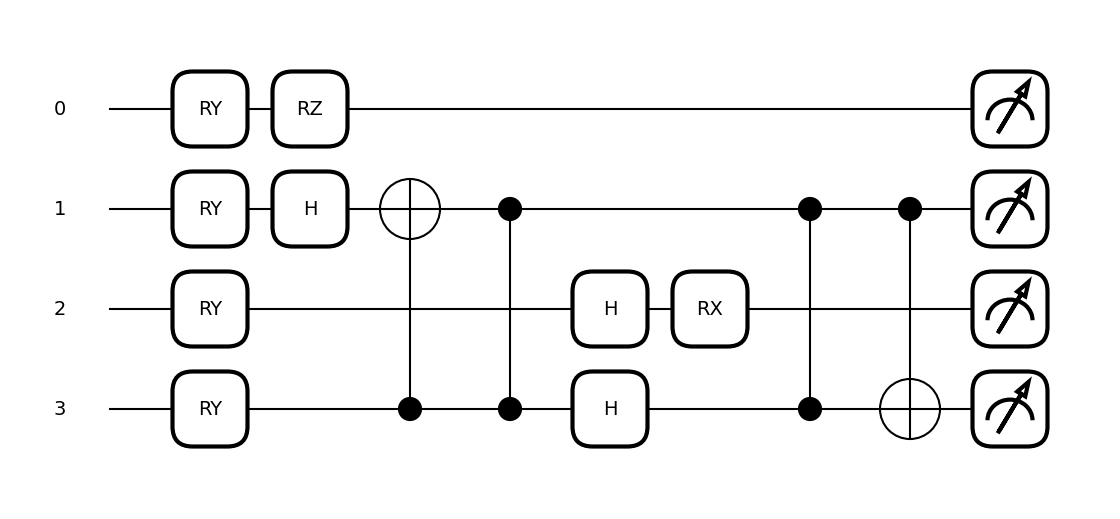

In [ ]:
num = 21
circuit_to_test = final_population[0][0]
fig, ax = qml.draw_mpl(circuit)([1.0,4,54,44], circuit_to_test)
plt.savefig(f"./results/circuit{num}")
fig.show()

In [ ]:
for gate in circuit_to_test:
    print(f"qml.{gate}")

qml.Hadamard(wires=[1])
qml.CNOT(wires=[3, 1])
qml.RZ(0.8403015315443181, wires=[0])
qml.CZ(wires=[1, 3])
qml.Hadamard(wires=[2])
qml.Hadamard(wires=[3])
qml.RX(1.4487898710467513, wires=[2])
qml.CZ(wires=[1, 3])
qml.CNOT(wires=[1, 3])


In [ ]:
n_epochs = 20
n_train = 50
n_test = 10

train_images, test_images = load_dataset(n_train, n_test, batch_size)
q_train, q_test = quanvolute_train_test(train_images, test_images, circuit_to_test)

TypeError: 'DataLoader' object is not subscriptable

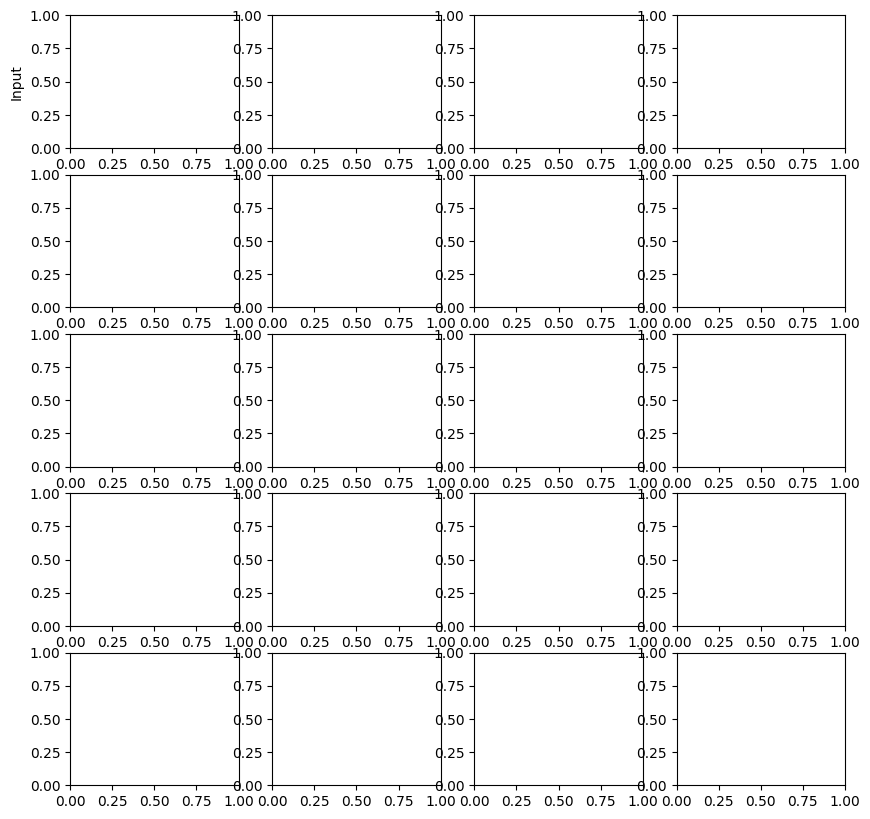

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for batch_idx, (data, labels) in enumerate(q_train):  # Iterate over batches
    random_indices = random.sample(range(len(data)), n_samples)  # Indices within batch

    for k, index in enumerate(random_indices):
        axes[0, 0].set_ylabel("Input")
        if k != 0:
            axes[0, k].yaxis.set_visible(False)
        axes[0, k].imshow(data[index, :, :, 0].numpy(), cmap="gray")  # Convert to NumPy if needed

        for c in range(n_channels):
            axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
            if k != 0:
                axes[c, k].yaxis.set_visible(False)
            # Assuming q_train outputs tensors compatible with indexing
            axes[c + 1, k].imshow(q_train[batch_idx][index, :, :, c].numpy(), cmap="gray")

    plt.tight_layout()
    plt.savefig(f"./results/output{batch_idx}.png")  # Save per batch, adjust as needed
    plt.show()
    break